In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

#### Step 1: Backbone Network


In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  # 1 input channel (grayscale), 16 output channels, 3x3 kernel
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        return x

In [4]:
image = torch.tensor(np.arange(64).reshape(1, 1, 8, 8), dtype=torch.float32)  # 1x1x8x8

# Initialize and run the backbone network
model = SimpleCNN()
feature_map = model(image)

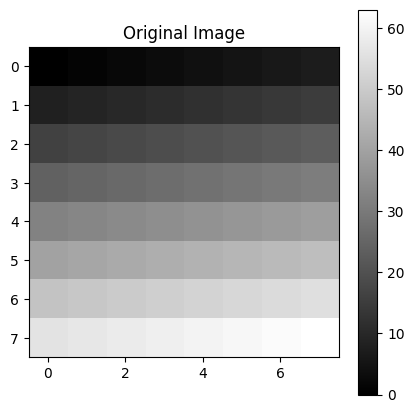

In [5]:
# Visualization
def visualize_tensor(tensor, title):
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor.squeeze().detach().numpy(), cmap='gray')
    plt.title(title)
    plt.colorbar()
    plt.show()

visualize_tensor(image, "Original Image")


In [6]:
image.shape, feature_map.shape

(torch.Size([1, 1, 8, 8]), torch.Size([1, 32, 2, 2]))

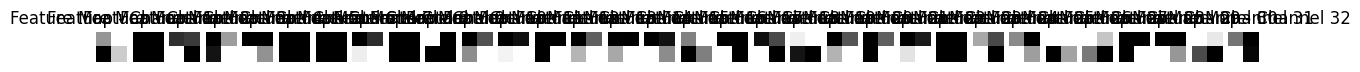

In [7]:
# Visualization function
def visualize_tensor(tensor, title):
    tensor = tensor.squeeze().detach().numpy()
    if tensor.ndim == 3:  # Handle the case of feature maps with channels
        num_channels = tensor.shape[0]
        plt.figure(figsize=(15, 5))
        for i in range(num_channels):
            plt.subplot(1, num_channels, i+1)
            plt.imshow(tensor[i, :, :], cmap='gray')
            plt.title(f'{title} - Channel {i+1}')
            plt.axis('off')
        plt.show()
    elif tensor.ndim == 2:
        plt.figure(figsize=(5, 5))
        plt.imshow(tensor, cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()
    else:
        raise ValueError(f"Unsupported tensor shape: {tensor.shape}")
visualize_tensor(feature_map, "Feature Map")


#### Step 2: Region Proposal Network (RPN)


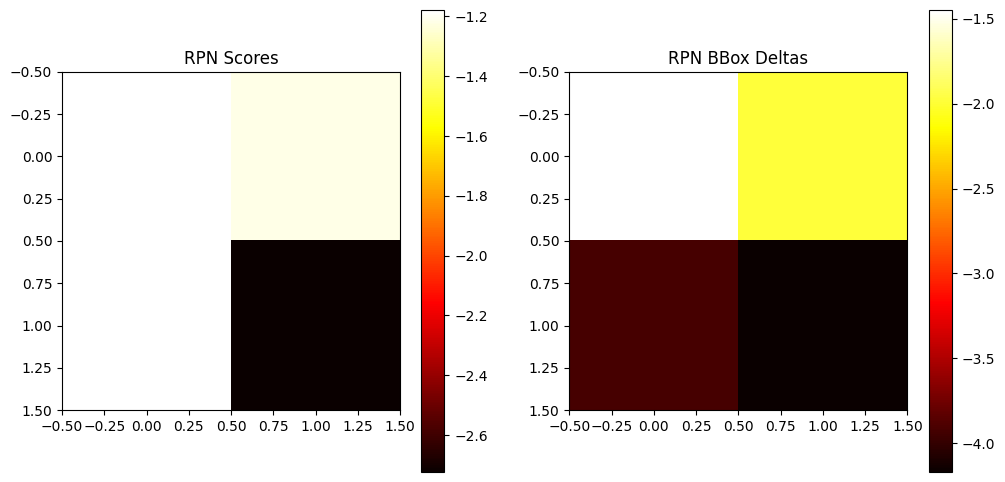

torch.Size([1, 18, 2, 2])
torch.Size([1, 36, 2, 2])


In [8]:
class RPN(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super(RPN, self).__init__()
        self.conv = nn.Conv2d(in_channels, mid_channels, 3, padding=1)
        self.score = nn.Conv2d(mid_channels, 9 * 2, 1)  # 9 anchors, 2 scores (foreground/background)
        self.bbox = nn.Conv2d(mid_channels, 9 * 4, 1)  # 9 anchors, 4 coordinates

    def forward(self, x):
        x = F.relu(self.conv(x))
        scores = self.score(x)
        bbox_deltas = self.bbox(x)
        return scores, bbox_deltas

# Initialize and run the RPN
rpn = RPN(32, 128)
scores, bbox_deltas = rpn(feature_map)

# Visualization of RPN outputs
def visualize_rpn_outputs(scores, bbox_deltas):
    scores = scores.squeeze().detach().numpy().reshape(9, 2, *scores.shape[2:])
    bbox_deltas = bbox_deltas.squeeze().detach().numpy().reshape(9, 4, *bbox_deltas.shape[2:])
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(scores[0, 0, :, :], cmap='hot')
    plt.title("RPN Scores")
    plt.colorbar()
    
    plt.subplot(1, 2, 2)
    plt.imshow(bbox_deltas[0, 0, :, :], cmap='hot')
    plt.title("RPN BBox Deltas")
    plt.colorbar()
    plt.show()

visualize_rpn_outputs(scores, bbox_deltas)
print(scores.shape)
print(bbox_deltas.shape)

#### Step 3: RoI Pooling

In [18]:
from torchvision.ops import roi_align

# Dummy proposals (x1, y1, x2, y2)
proposals = torch.tensor([
    [0, 0, 4, 4],
    [2, 2, 6, 6]
], dtype=torch.float32)

# Convert proposals to (batch_index, x1, y1, x2, y2) format
batch_indices = torch.zeros(proposals.size(0), 1)
print(batch_indices)
proposals = torch.cat((batch_indices, proposals), dim=1)
print(proposals)

# RoI Align
pooled_features = roi_align(feature_map, proposals, output_size=(2, 2))
pooled_features.shape



tensor([[0.],
        [0.]])
tensor([[0., 0., 0., 4., 4.],
        [0., 2., 2., 6., 6.]])


torch.Size([2, 32, 2, 2])

In [11]:
# Visualization function
def visualize_tensor(tensor, title):
    tensor = tensor.squeeze().detach().numpy()
    if tensor.ndim == 3:  # Handle the case of feature maps with channels
        num_channels = tensor.shape[0]
        plt.figure(figsize=(15, 5))
        for i in range(num_channels):
            plt.subplot(1, num_channels, i+1)
            plt.imshow(tensor[i, :, :], cmap='gray')
            plt.title(f'{title} - Channel {i+1}')
            plt.axis('off')
        plt.show()
    elif tensor.ndim == 2:
        plt.figure(figsize=(5, 5))
        plt.imshow(tensor, cmap='gray')
        plt.title(title)
        plt.colorbar()
        plt.show()
    elif tensor.ndim == 4:  # Handle the case of pooled features
        num_regions = tensor.shape[0]
        num_channels = tensor.shape[1]
        for region in range(num_regions):
            plt.figure(figsize=(15, 5))
            for channel in range(num_channels):
                plt.subplot(4, 8, channel + 1)  # Adjust this line if num_channels is not 32
                plt.imshow(tensor[region, channel, :, :], cmap='gray')
                plt.title(f'Region {region+1} - Channel {channel+1}')
                plt.axis('off')
            plt.show()
    else:
        raise ValueError(f"Unsupported tensor shape: {tensor.shape}")

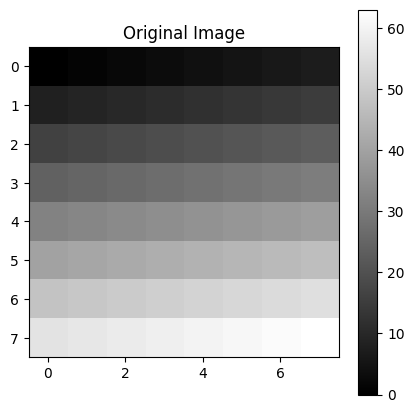

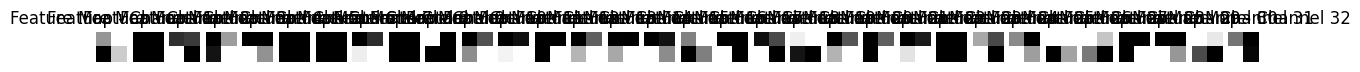

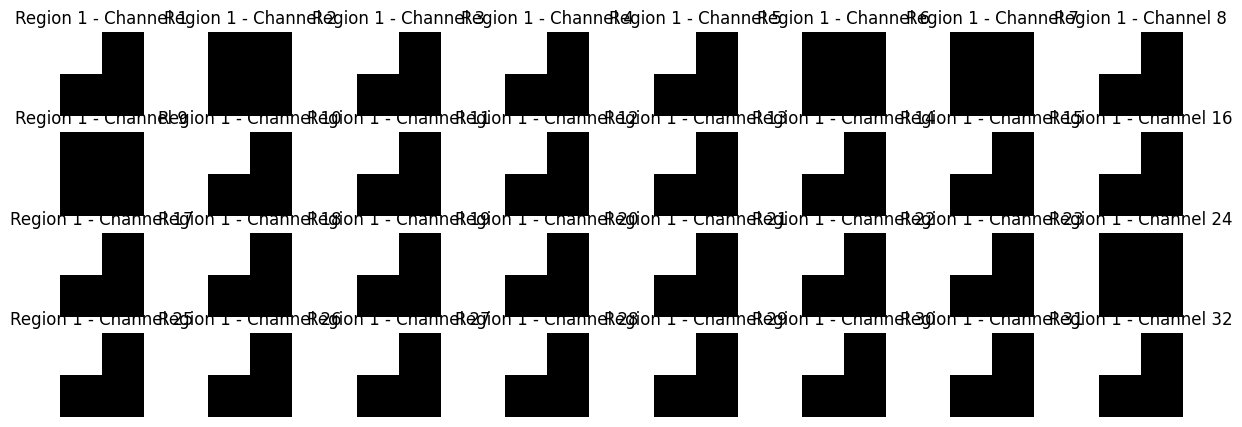

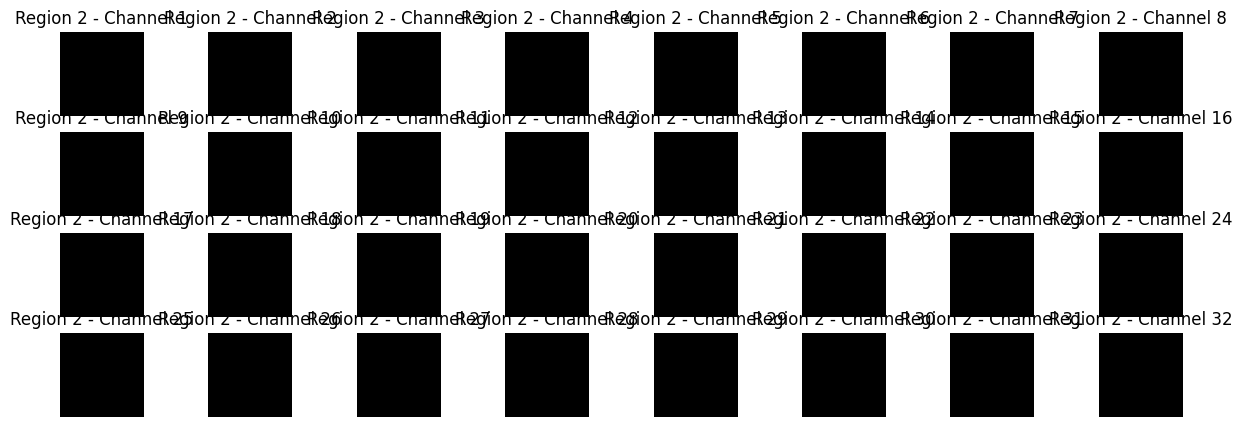

In [12]:
# Visualization
visualize_tensor(image.squeeze(), "Original Image")
visualize_tensor(feature_map.squeeze(), "Feature Map")
visualize_tensor(pooled_features, "Pooled Features")

#### Step 4: Detection Network


In [19]:
class DetectionNetwork(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(DetectionNetwork, self).__init__()
        self.fc1 = nn.Linear(in_channels * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, num_classes + 4)  # num_classes scores + 4 bbox coordinates

    def forward(self, x):
        x = x.view(x.size(0), -1)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = self.fc2(x)
        print(x.shape)  
        return x

# Initialize and run the detection network
detection_network = DetectionNetwork(32, 2)  # 2 classes (foreground/background)
pooled_features_flat = pooled_features.view(pooled_features.size(0), -1)
detection_output = detection_network(pooled_features_flat)
print("Detection Output Shape:", detection_output.shape)


torch.Size([2, 128])
torch.Size([2, 1024])
torch.Size([2, 6])
Detection Output Shape: torch.Size([2, 6])


#### Step 5: Non-Maximum Suppression (NMS)


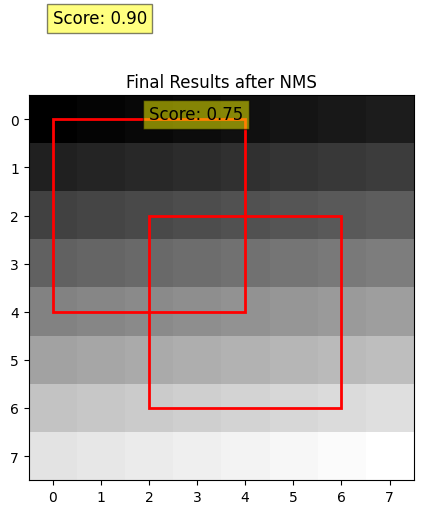

In [14]:
from torchvision.ops import nms

# Dummy scores and bounding boxes
scores = torch.tensor([0.9, 0.75], dtype=torch.float32)
bboxes = torch.tensor([
    [0, 0, 4, 4],
    [2, 2, 6, 6]
], dtype=torch.float32)

# Apply NMS
keep_indices = nms(bboxes, scores, iou_threshold=0.5)
final_bboxes = bboxes[keep_indices]
final_scores = scores[keep_indices]

# Visualization
def visualize_final_results(bboxes, scores):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze().detach().numpy(), cmap='gray')
    for i in range(bboxes.size(0)):
        bbox = bboxes[i].numpy()
        plt.gca().add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], 
                                          fill=False, edgecolor='red', linewidth=2))
        plt.text(bbox[0], bbox[1] - 2, f'Score: {scores[i]:.2f}', bbox=dict(facecolor='yellow', alpha=0.5),
                 fontsize=12, color='black')
    plt.title("Final Results after NMS")
    plt.show()

visualize_final_results(final_bboxes, final_scores)


#### Complete Faster R-CNN Pipeline


In [15]:
class FasterRCNN(nn.Module):
    def __init__(self, num_classes):
        super(FasterRCNN, self).__init__()
        self.backbone = SimpleCNN()
        self.rpn = RPN(32, 128)
        self.roi_align = roi_align
        self.detection_network = DetectionNetwork(32, num_classes)

    def forward(self, image, proposals):
        feature_map = self.backbone(image)
        scores, bbox_deltas = self.rpn(feature_map)
        batch_indices = torch.zeros(proposals.size(0), 1)
        proposals = torch.cat((batch_indices, proposals), dim=1)
        pooled_features = self.roi_align(feature_map, proposals, output_size=(2, 2))
        pooled_features_flat = pooled_features.view(pooled_features.size(0), -1)
        detection_output = self.detection_network(pooled_features_flat)
        return detection_output

# Initialize and run the Faster R-CNN
faster_rcnn = FasterRCNN(num_classes=2)
proposals = torch.tensor([
    [0, 0, 4, 4],
    [2, 2, 6, 6]
], dtype=torch.float32)
detection_output = faster_rcnn(image, proposals)
print("Faster R-CNN Output:", detection_output)


Faster R-CNN Output: tensor([[ 0.1728, -1.1750,  1.4079,  1.0458, -0.7871, -0.0473],
        [ 0.0098,  0.0075,  0.0189,  0.0494, -0.0133, -0.0483]],
       grad_fn=<AddmmBackward0>)
